# A notebook to run analyses 

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from flarestack.analyses.ccsn.necker_2019.ccsn_helpers import sn_cats, updated_sn_catalogue_name
import matplotlib.pyplot as plt
import numpy as np

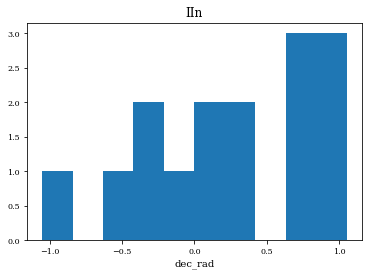

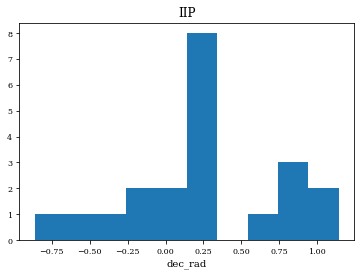

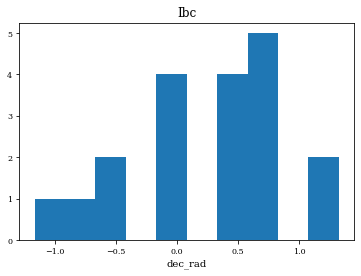

In [3]:
for cat in sn_cats:
    loaded_cat = np.load(updated_sn_catalogue_name(cat))
    plt.figure()
    ax = plt.subplot()
    ax.hist(loaded_cat['dec_rad'])
    ax.set_xlabel('dec_rad')
    ax.set_title(cat)
    plt.show()
    plt.close()

In [4]:
for cat in sn_cats:
    loaded_cat = np.load(updated_sn_catalogue_name(cat))
    perc_south = len(loaded_cat[loaded_cat['dec_rad'] < np.deg2rad(-5)]) / len(loaded_cat)
    perc_north = 1 - perc_south
    print(f'{cat}: {perc_south*100:.0f}\% in the south, {perc_north*100:.0f}\% in the north')

IIn: 33\% in the south, 67\% in the north
IIP: 24\% in the south, 76\% in the north
Ibc: 21\% in the south, 79\% in the north


In [3]:
import numpy as np
import argparse
from flarestack.core.results import ResultsHandler
from flarestack.data.icecube import ps_v002_p01, diffuse_8_year
from flarestack.shared import plot_output_dir, flux_to_k, analysis_pickle_path, inj_dir_name, name_pickle_output_dir
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
from flarestack.analyses.ccsn.necker_2019.ccsn_helpers import sn_cats, updated_sn_catalogue_name, \
    raw_output_dir
from flarestack.analyses.ccsn.necker_2019.skylab_crosscheck_data import skylab_data, skylab_northern_only_data, dir_path
from flarestack.analyses.ccsn import get_sn_color
from flarestack.cluster import analyse, Submitter
from flarestack.cluster.run_desy_cluster import wait_for_cluster
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from flarestack.utils.custom_dataset import custom_dataset
import os
import logging

logging.getLogger().setLevel("INFO")
logging.debug('logging level is DEBUG')
logging.getLogger('matplotlib').setLevel('INFO')

In [13]:
dang = 5
smoothing = 'flarestack'
seasons = ''
cluster = True
ntrials = 1000
gammas = [2, 2.5, 3]
ref_time_mjd = np.nan
injection_bandwidth = 1
mh_name = 'large_catalogue'
injector = 'low_memory_injector'
analyse = False

In [14]:
injection_energy = {
    "energy_pdf_name": "power_law"
}

injection_time = {
    'time_pdf_name': 'steady'
}

llh_energy = {
    "energy_pdf_name": "power_law"
}

llh_time = {
    'time_pdf_name': 'steady'
}

seasons_str = ''
if isinstance(seasons, list):
    for s in seasons:
        seasons_str += '_' + s 
        
inj_str = 'mcinjector' if injector == 'mc_injector' else 'lowmemoryinj' if injector == 'low_memory_injector' else ''

raw = raw_output_dir + f"/skylab_crosscheck_test_{inj_str}/bandw{injection_bandwidth}_{mh_name}_{smoothing}-smoothing_dang{dang}{seasons_str}"
if not os.path.exists(plot_output_dir(raw)):
    os.makedirs(plot_output_dir(raw))

In [15]:
full_res = dict()
submitters = []
sindec = dict()

In [16]:
for cat in sn_cats:

    name = f'{raw}/{cat}'
    cat_path = updated_sn_catalogue_name(cat)
    catalogue = np.load(cat_path)

    new_dtype = catalogue.dtype.descr
    new_dtype[1] = ('ref_time_mjd', '<f8')
    catalogue = np.asarray(catalogue, dtype=new_dtype)
    catalogue['ref_time_mjd'] = [ref_time_mjd] * len(catalogue)
    catalogue['distance_mpc'] = np.array([1] * len(catalogue))
    w = [1] * len(catalogue)
    this_cat_path = f'{cat_path.split(".npy")[0]}_used.npy'
    np.save(this_cat_path, catalogue)
    closest_src = np.sort(catalogue, order="distance_mpc")[0]
    cat_res = dict()

    for gamma in gammas:

        injection_energy['gamma'] = gamma

        inj_dict = {
            'injector_name': injector,
            'injection_energy_pdf': injection_energy,
            'injection_sig_time_pdf': injection_time,
            'injection_declination_bandwidth': injection_bandwidth
        }

        llh_dict = {
            "llh_name": "standard" if not mh_name in ['large_catalogue', 'experimental_mh'] else 'standard_matrix',
            "llh_energy_pdf": llh_energy,
            "llh_sig_time_pdf": llh_time,
            "llh_bkg_time_pdf": {"time_pdf_name": "steady"},
            "gamma_precision": smoothing,
            "smoothing_order": smoothing,
            'spatial_box_width': dang
        }

        full_name = f'{name}/{gamma:.2f}'
        
        skylab_file = f'{dir_path}/{cat}_{gamma:.2f}_kernel1_all.npy'
        skylab_res = np.load(skylab_file)
        scale = flux_to_k(float(skylab_res[0].decode()))

#         length = 365 * 7

#         scale = 0.5 * (flux_to_k(reference_sensitivity(
#             np.sin(closest_src["dec_rad"]), gamma=gamma
#         ) * 40 * math.sqrt(float(len(catalogue)))) * 200.) / length

#         if cat == 'IIn':
#             scale *= 0.3
#         if cat == 'IIP':
#             scale *= 1

#         if seasons == ['IC86_1'] or seasons == ['IC86_2011']:
#             scale *= 2

#         # if 'large_catalogue' in mh_name:
#         #     scale /= 4

#         if gamma == 3:
#             if cat == 'IIn':
#                 scale /= 5
#             if cat == 'IIP':
#                 scale /= 1.5

#         if gamma == 2.5:
#             if cat == 'Ibc':
#                 scale *= 1.3

        data = ps_v002_p01
        if seasons:
            data = data.get_seasons(*seasons)

        dataset = custom_dataset(data, catalogue, llh_dict["llh_sig_time_pdf"])
        logging.debug(f'{dataset.keys()}')

        mh_dict = {
            "name": full_name,
            "mh_name": mh_name,
            "dataset": dataset,
            "catalogue": this_cat_path,
            "inj_dict": inj_dict,
            "llh_dict": llh_dict,
            "scale": scale,
            "n_trials": ntrials,
            "n_steps": 10,
            "allow_extrapolated_sensitivity": False
        }

        submitter = Submitter.get_submitter(mh_dict, cluster, 20,
                                            do_sensitivity_scale_estimation="quick_injections",
                                            remove_old_results=True,
                                            cluster_cpu=1,
                                            n_jobs=cluster,
                                            h_cpu='01:59:59',
                                            trials_per_task=2)

        logging.debug(f'adding {submitter}')
        submitters.append(submitter)

        cat_res[gamma] = mh_dict

    full_res[cat] = cat_res

DEBUG:root:dict_keys(['IC40', 'IC59', 'IC79', 'IC86_1', 'IC86_234'])
DEBUG:root:adding 
----- Submitter for analyses/ccsn/necker_2019/skylab_crosscheck_test_lowmemoryinj/bandw1_large_catalogue_flarestack-smoothing_dang5/IIn/2.00 -----
using cluster 
using 20 CPUs locally
job-id: None 
quick_injections scale estimation 
cluster kwargs: 
  cluster_cpu: 1 
  n_jobs: True 
  h_cpu: 01:59:59 
  trials_per_task: 2 

DEBUG:root:dict_keys(['IC40', 'IC59', 'IC79', 'IC86_1', 'IC86_234'])
DEBUG:root:adding 
----- Submitter for analyses/ccsn/necker_2019/skylab_crosscheck_test_lowmemoryinj/bandw1_large_catalogue_flarestack-smoothing_dang5/IIn/2.50 -----
using cluster 
using 20 CPUs locally
job-id: None 
quick_injections scale estimation 
cluster kwargs: 
  cluster_cpu: 1 
  n_jobs: True 
  h_cpu: 01:59:59 
  trials_per_task: 2 

DEBUG:root:dict_keys(['IC40', 'IC59', 'IC79', 'IC86_1', 'IC86_234'])
DEBUG:root:adding 
----- Submitter for analyses/ccsn/necker_2019/skylab_crosscheck_test_lowmemoryinj/ba

In [17]:
if analyse:
    logging.getLogger().setLevel('INFO')
    for s in submitters[8:]:
        s.analyse()

In [18]:
if analyse:
    logging.getLogger().setLevel('DEBUG')
    for s in submitters:
        logging.info(f'waiting for {s}')
        s.wait_for_job()

In [19]:
stacked_sens_flux = {}

for cat_name, cat_res in full_res.items():
    stacked_sens_flux[cat_name] = dict()

    for gamma, rh_dict in cat_res.items():
        rh = ResultsHandler(rh_dict)

        stacked_sens_flux[cat_name][gamma] = {
            'sens': rh.sensitivity,
            'sens_e': rh.sensitivity_err,
            'sens_n': rh.sensitivity * rh.flux_to_ns,
            'sens_n_e': rh.sensitivity_err * rh.flux_to_ns
        }

DEBUG:flarestack.core.results:Conversion ratio of flux to n_s: 10499283351.08
INFO:flarestack.core.results:Saving bias plot to /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/ccsn/necker_2019/skylab_crosscheck_test_lowmemoryinj/bandw1_large_catalogue_flarestack-smoothing_dang5/IIn/2.00/bias_n_s.pdf
INFO:flarestack.core.results:Saving bias plot to /afs/ifh.de/user/n/neckerja/scratch/fs_dev_branch/flarestack__data/output/plots/analyses/ccsn/necker_2019/skylab_crosscheck_test_lowmemoryinj/bandw1_large_catalogue_flarestack-smoothing_dang5/IIn/2.00/bias_gamma.pdf
INFO:flarestack.core.results:Fraction of overfluctuations is 0.50 above 0.02 (N_trials=9999) (Scale=0)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.66 above 0.02 (N_trials=1000) (Scale=0.2544)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.77 above 0.02 (N_trials=1000) (Scale=0.5087)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.86 above 0.0

DEBUG:root:skylab results: [b'1.6004953214080482e-09' b'4.324355891155513e-11' b'10.334061157214837'
 b'0.2792145509394466' b'IIn' b'2']
DEBUG:root:x=IIn, y=10.334061157214837, yerr=0.2792145509394466
DEBUG:root:skylab results: [b'4.2025131655056234e-07' b'1.26436934021001e-08' b'22.54552565773986'
 b'0.6783053443958629' b'IIn' b'2.5']
DEBUG:root:x=IIn, y=22.54552565773986, yerr=0.6783053443958629
DEBUG:root:skylab results: [b'4.021493927771398e-05' b'1.084838283834842e-06' b'41.23552071223634'
 b'1.1123694906904618' b'IIn' b'3']
DEBUG:root:x=IIn, y=41.23552071223634, yerr=1.1123694906904618
DEBUG:root:skylab results: [b'1.3521561877363812e-09' b'4.304308162029738e-11' b'10.656803751494312'
 b'0.33923719600393554' b'IIP' b'2']
DEBUG:root:x=IIP, y=10.656803751494312, yerr=0.33923719600393554
DEBUG:root:skylab results: [b'4.386582824347133e-07' b'1.1997688174384437e-08' b'26.723347528173292'
 b'0.7309069575506051' b'IIP' b'2.5']
DEBUG:root:x=IIP, y=26.723347528173292, yerr=0.730906957550

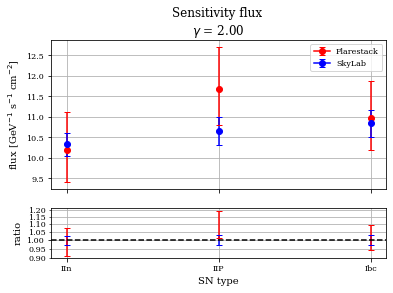

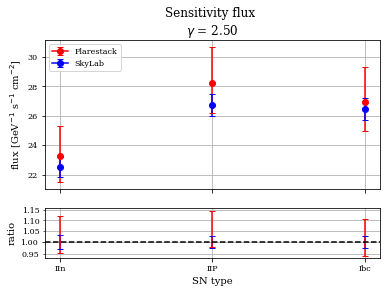

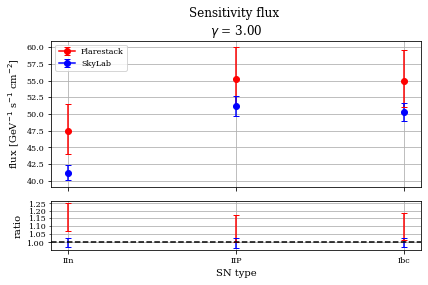

In [20]:
logging.getLogger().setLevel('DEBUG')
for kernel in [1]:

    figaxs = {}

    for cat_name, cat_dict in stacked_sens_flux.items():

        for gamma, sens_dict in cat_dict.items():

            fs_label = ''
            sl_label = ''
            ref_label = ''
            if gamma not in figaxs:
                figaxs[gamma] = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
                fs_label = 'Flarestack'
                sl_label = 'SkyLab'
                ref_label = 'reference PS sensitivity'

            figaxs[gamma][1][0].errorbar([cat_name], sens_dict['sens_n'], yerr=np.atleast_2d(sens_dict['sens_n_e']).T,
                                         color='red', label=fs_label, marker='o', capsize=3)

           
            #skylab_res = skylab_data(gamma, cat_name, seasons=seasons, kernel=kernel)
            skylab_file = f'{dir_path}/{cat_name}_{gamma:.2f}_kernel{kernel}_all.npy'
            skylab_res = np.load(skylab_file)
            logging.debug(f'skylab results: {skylab_res}')
            
            if not isinstance(skylab_res, type(None)):
                if ((skylab_res[4].decode()) != cat_name) or (float(skylab_res[5].decode()) != gamma):
                    raise Exception(f'Skylab results refers to SNe {skylab_res[4]} and gamma={skylab_res[5]} '
                                    f'not to SNe {cat_name} and gamma={gamma:.2f}')

                sres = float(skylab_res[2].decode())
                relative_to = sres

                logging.debug(f'x={cat_name}, y={float(skylab_res[2].decode())}, yerr={float(skylab_res[3].decode())}')
                figaxs[gamma][1][0].errorbar([cat_name], sres, yerr=float(skylab_res[3].decode()),
                                             label=sl_label, color='blue', marker='o', capsize=3)
                figaxs[gamma][1][1].errorbar([cat_name], sres/relative_to,
                                             yerr=float(skylab_res[3].decode())/relative_to,
                                             color='blue', marker='', capsize=3)
                figaxs[gamma][1][1].errorbar([cat_name], sens_dict['sens_n']/relative_to,
                                             yerr=np.atleast_2d(sens_dict['sens_n_e']).T/relative_to,
                                             color='red', marker='', capsize=3)

            else:
                logging.info(f'No skylab results for SNe {cat_name} gamma={gamma}')

    # saving plots
    for gamma, figax in figaxs.items():

        figax[1][0].legend()
        figax[1][0].grid()
        figax[1][0].set_ylabel(r'flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]')
        figax[1][0].set_title('Sensitivity flux \n'
                              f'$\gamma$ = {gamma:.2f}')

        figax[1][1].axhline(1, color='k', ls='--', )
        figax[1][1].set_xlabel('SN type')
        figax[1][1].set_ylabel('ratio')
        figax[1][1].set_yscale('log')
        ratio_ylim = figax[1][1].get_ylim()
#         yticks = [round(min(ratio_ylim), 1), round(max(ratio_ylim), 1)]
#         figax[1][1].set_yticks([yticks[0], 1, yticks[1]], minor=False)
        # figax[1][1].set_yticks([], minor=True)
#         figax[1][1].set_yticklabels([f'{yticks[0]:.1f}', '1', f'{yticks[1]:.1f}'], minor=False)
#         figax[1][1].set_yticklabels([], minor=True)
        formatter = mtick.StrMethodFormatter('{x:.2f}')
        figax[1][1].yaxis.set_major_formatter(formatter)
        figax[1][1].yaxis.set_minor_formatter(formatter)
        figax[1][1].grid(which='both')
        
        fig_filename = os.path.join(plot_output_dir(raw), f'{gamma}_number_sens.pdf')
        logging.debug(f'saving under {fig_filename}')
        figax[0].savefig(fig_filename)

        plt.tight_layout()

plt.show()
plt.close()

DEBUG:root:skylab results: [b'1.6004953214080482e-09' b'4.324355891155513e-11' b'10.334061157214837'
 b'0.2792145509394466' b'IIn' b'2']
DEBUG:root:skylab results: [b'1.6004953214080482e-09' b'4.324355891155513e-11' b'10.334061157214837'
 b'0.2792145509394466' b'IIn' b'2']
DEBUG:root:x=IIn, y=1.6004953214080482e-09, yerr=4.324355891155513e-11
DEBUG:root:skylab results: [b'4.2025131655056234e-07' b'1.26436934021001e-08' b'22.54552565773986'
 b'0.6783053443958629' b'IIn' b'2.5']
DEBUG:root:skylab results: [b'4.2025131655056234e-07' b'1.26436934021001e-08' b'22.54552565773986'
 b'0.6783053443958629' b'IIn' b'2.5']
DEBUG:root:x=IIn, y=4.2025131655056234e-07, yerr=1.26436934021001e-08
DEBUG:root:skylab results: [b'4.021493927771398e-05' b'1.084838283834842e-06' b'41.23552071223634'
 b'1.1123694906904618' b'IIn' b'3']
DEBUG:root:skylab results: [b'4.021493927771398e-05' b'1.084838283834842e-06' b'41.23552071223634'
 b'1.1123694906904618' b'IIn' b'3']
DEBUG:root:x=IIn, y=4.021493927771398e-05

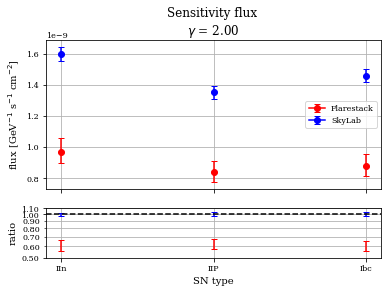

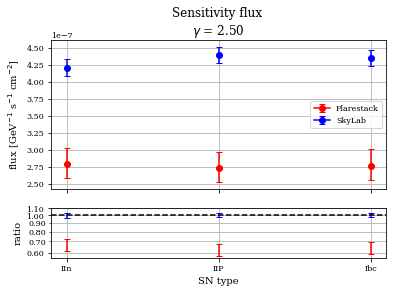

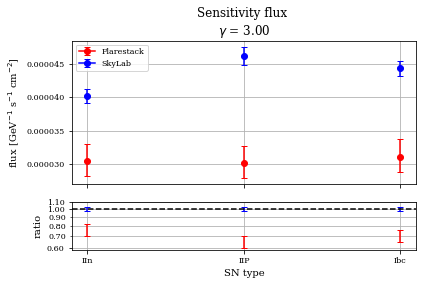

In [21]:
logging.getLogger().setLevel('DEBUG')
for kernel in [1]:

    figaxs = {}

    for cat_name, cat_dict in stacked_sens_flux.items():

        for gamma, sens_dict in cat_dict.items():

            fs_label = ''
            sl_label = ''
            ref_label = ''
            if gamma not in figaxs:
                figaxs[gamma] = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
                fs_label = 'Flarestack'
                sl_label = 'SkyLab'
                ref_label = 'reference PS sensitivity'

            figaxs[gamma][1][0].errorbar([cat_name], sens_dict['sens'], yerr=np.atleast_2d(sens_dict['sens_e']).T,
                                         color='red', label=fs_label, marker='o', capsize=3)

           
            skylab_file = f'{dir_path}/{cat_name}_{gamma:.2f}_kernel{kernel}_all.npy'
            skylab_res = np.load(skylab_file)
            logging.debug(f'skylab results: {skylab_res}')
            logging.debug(f'skylab results: {skylab_res}')
            
            if not isinstance(skylab_res, type(None)):
                if ((skylab_res[4].decode()) != cat_name) or (float(skylab_res[5].decode()) != gamma):
                    raise Exception(f'Skylab results refers to SNe {skylab_res[4]} and gamma={skylab_res[5]} '
                                    f'not to SNe {cat_name} and gamma={gamma:.2f}')

                sres = float(skylab_res[0].decode())
                relative_to = sres

                logging.debug(f'x={cat_name}, y={float(skylab_res[0].decode())}, yerr={float(skylab_res[1].decode())}')
                figaxs[gamma][1][0].errorbar([cat_name], sres, yerr=float(skylab_res[1].decode()),
                                             label=sl_label, color='blue', marker='o', capsize=3)
                figaxs[gamma][1][1].errorbar([cat_name], sres/relative_to,
                                             yerr=float(skylab_res[1].decode())/relative_to,
                                             color='blue', marker='', capsize=3)
                figaxs[gamma][1][1].errorbar([cat_name], sens_dict['sens']/relative_to,
                                             yerr=np.atleast_2d(sens_dict['sens_e']).T/relative_to,
                                             color='red', marker='', capsize=3)

            else:
                logging.info(f'No skylab results for SNe {cat_name} gamma={gamma}')

    # saving plots
    for gamma, figax in figaxs.items():

        figax[1][0].legend()
        figax[1][0].grid()
        figax[1][0].set_ylabel(r'flux [GeV$^{-1}$ s$^{-1}$ cm$^{-2}$]')
        figax[1][0].set_title('Sensitivity flux \n'
                              f'$\gamma$ = {gamma:.2f}')

        figax[1][1].axhline(1, color='k', ls='--', )
        figax[1][1].set_xlabel('SN type')
        figax[1][1].set_ylabel('ratio')
        figax[1][1].set_yscale('log')
        ratio_ylim = figax[1][1].get_ylim()
        yticks = [round(min(ratio_ylim), 1), round(max(ratio_ylim), 1)]
        figax[1][1].set_yticks([yticks[0], 1, yticks[1]], minor=False)
#         yticks = [round(min(ratio_ylim), 1), round(max(ratio_ylim), 1)]
#         figax[1][1].set_yticks([yticks[0], 1, yticks[1]], minor=False)
        # figax[1][1].set_yticks([], minor=True)
#         figax[1][1].set_yticklabels([f'{yticks[0]:.1f}', '1', f'{yticks[1]:.1f}'], minor=False)
#         figax[1][1].set_yticklabels([], minor=True)
        formatter = mtick.StrMethodFormatter('{x:.2f}')
        figax[1][1].yaxis.set_major_formatter(formatter)
        figax[1][1].yaxis.set_minor_formatter(formatter)
        figax[1][1].grid(which='both')
        
        fig_filename = os.path.join(plot_output_dir(raw), f'{gamma}_flux_sens.pdf')
        logging.debug(f'saving under {fig_filename}')
        figax[0].savefig(fig_filename)

        plt.tight_layout()

plt.show()
plt.close()